### Emsembles of mixed-effects and ARIMA models to forecast internet access in underserved Canadian communities.
* For 2022 SSC case competition #2
    * https://ssc.ca/en/case-study/towards-a-clear-understanding-rural-internet-what-statistical-measures-can-be-used-assess
* Authors: **Joosung (Sonny) Min, Renny Doig, Daisy Yu, and Olga Vishnyakova** (supervisor: **Dr. Lloyd T. Elliott**)



Overview of this notebook:
1. Data description
2. Feature selection - **Linear regression**
3. Missing data handling - **Data aggregation** & **Imputation**
4. Statistical modelling - **ARIMA** & **Mixed-effects model (ME)**
5. Weight selection for ARIMA and ME - **grid search**
6. Results
    * Expression by SACTYPE
    * Heatmap


#### 1. Data description


In [ ]:
# Missing data handling
## Data aggregation
## Missing data imputation
### We could have used k-nearest neighbours imputation?

# Methods
## ARIMA
## Linear mixed-effects

# Results
## Barplot by SACTYPE
## Heatmap

In [272]:
## Load packages
import numpy as np
import pandas as pd
import pickle
import os
!pip install geopandas &> /dev/null
import geopandas

print(os.getcwd())
os.chdir('/content/drive/MyDrive/personal/ssc22-case-comp/sonny_dir/')
print(os.getcwd())

/content/drive/MyDrive/shared/ssc22-case-comp/sonny_dir
/content/drive/MyDrive/personal/ssc22-case-comp/sonny_dir


In [7]:
# Load data
## The original data for the case study competition #2 can be downloaded here: 
## https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/case-study/ookla-canada-speed-tiles.zip

## To make the data easier to load, we converted the original data to a python pickle file
## Here, we load the pickle file

with open('../dataset/python_canada-speed-data.p', 'rb') as file:
    can_speeds = pickle.load(file)
can_speeds.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,CDUID,CDNAME,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry
0,0023331133131332,11910,1408,27,1,1,2019,Q1,fixed,61,...,6101,Region 1,61010033,8,590.0,None,None,None,None,"POLYGON ((4593360.869 4089469.904, 4593533.055..."
1,0023331133133011,14969,1554,25,1,1,2019,Q1,fixed,61,...,6101,Region 1,61010033,8,590.0,None,None,None,None,"POLYGON ((4592705.709 4089714.238, 4592877.874..."
2,0032202103303220,5038,1317,54,1,1,2019,Q1,fixed,61,...,6101,Region 1,61010054,8,330.0,None,None,None,None,"POLYGON ((4736491.486 4146142.702, 4736658.777..."
3,0032220031120102,13419,6169,50,4,1,2019,Q1,fixed,61,...,6101,Region 1,61010045,8,275.0,None,None,None,None,"POLYGON ((4642710.684 4070147.116, 4642884.538..."
4,0032220031120103,13587,1095,28,2,1,2019,Q1,fixed,61,...,6101,Region 1,61010045,8,275.0,0388,Inuvik,4,2,"POLYGON ((4642884.538 4070012.633, 4643058.404..."


In [8]:
can_speeds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2751464 entries, 0 to 2751463
Data columns (total 21 columns):
 #   Column      Dtype   
---  ------      -----   
 0   quadkey     object  
 1   avg_d_kbps  int64   
 2   avg_u_kbps  int64   
 3   avg_lat_ms  int64   
 4   tests       int64   
 5   devices     int64   
 6   year        object  
 7   quarter     object  
 8   conn_type   object  
 9   PRUID       object  
 10  PRNAME      object  
 11  CDUID       object  
 12  CDNAME      object  
 13  DAUID       object  
 14  SACTYPE     object  
 15  DA_POP      float64 
 16  PCUID       object  
 17  PCNAME      object  
 18  PCTYPE      object  
 19  PCCLASS     object  
 20  geometry    geometry
dtypes: float64(1), geometry(1), int64(5), object(14)
memory usage: 440.8+ MB


In [9]:
## combine year and quarter into one feature:
subset1 = can_speeds[['year', 'quarter']]
subset1['year_month'] = pd.to_datetime(subset1.year.map(str) + "-" + subset1.quarter.map(str))

can_speeds['date'] = subset1['year_month']
can_speeds2 = can_speeds.drop(columns= ['year', 'quarter'])

## We take is_rural = 1 for PCTYPE=NaN, 0 otherwise
can_speeds2['is_rural'] =  pd.isna(can_speeds2['PCTYPE'])

## -- later explain why we chose to drop these columns --
## Drop the unnecessary columns: 'avg_lat_ms', 'devices', 'PRNAME', 'CDNAME', 'DAUID', 'PCUID', 'PCTYPE', 'PCNAME', 'PCCLASS', 'geometry' 
can_speeds3 = pd.DataFrame(can_speeds2.drop(columns= ['quadkey', 'avg_lat_ms', 'devices', 'PRNAME', 'CDNAME', 'DAUID', 'PCUID', 'PCTYPE', 'PCNAME', 'PCCLASS', 'geometry', 'DA_POP' ]))
can_speeds3.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2751464 entries, 0 to 2751463
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   avg_d_kbps  int64         
 1   avg_u_kbps  int64         
 2   tests       int64         
 3   conn_type   object        
 4   PRUID       object        
 5   CDUID       object        
 6   SACTYPE     object        
 7   date        datetime64[ns]
 8   is_rural    bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 170.6+ MB


In [11]:
can_speeds3.to_csv('/content/drive/MyDrive/personal/ssc22-case-comp/sonny_dir/can_speeds_sub.csv', index=False)

In [ ]:
## Response variables: avg_d_kbps, avg_u_kbps
## Each quadkey has maximum 12 internet speed observations (2019-1Q to 2021-4Q, quarterly).
## However, many quadkeys have fewer than 12 observations, especially the regions in the northern parts of Canada(Nunavut, Northwestern territories, etc).
## To resolve the missing data problem, we applied the following methods:
#### Data aggregation
#### Imputation

### Data aggregation

* We grouped our data by: PRUID, CDUID, conn_type, SACTYPE, and is_rural
* The means are computed by taking the number of speed tests ('tests') as weights.

In [27]:
prs = sorted(can_speeds3.loc[:,'PRUID'].unique())
cds = sorted(can_speeds3.loc[:,'CDUID'].unique())
conn_types = sorted(can_speeds3.loc[:, 'conn_type'].unique())
SACTYPEs = sorted(can_speeds3.loc[:, 'SACTYPE'].unique())
is_rurals = sorted(can_speeds3.loc[:, 'is_rural'].unique())
dates = sorted(can_speeds3.loc[:, 'date'].unique())

In [249]:
group_columns = ['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural', 'date']

# compute weighted means of the download speeds
can_speeds3_d = can_speeds3.drop(columns = ['avg_u_kbps'])
grouped_df_d = can_speeds3_d.groupby(group_columns).apply(lambda x: np.average(x['avg_d_kbps'], weights=x['tests'])).to_frame(name='avg_d_kbps').reset_index()

# compute weighted means of the upload speeds
can_speeds3_u = can_speeds3.drop(columns = ['avg_d_kbps'])
grouped_df_u = can_speeds3_u.groupby(group_columns).apply(lambda x: np.average(x['avg_u_kbps'], weights=x['tests'])).to_frame(name='avg_u_kbps').reset_index()

# merge the two tables
grouped_df = pd.merge(grouped_df_d, grouped_df_u, how='inner', on=group_columns)

# convert kbps to mbps
grouped_df['avg_d_mbps'] = grouped_df.loc[:, 'avg_d_kbps']/1000
grouped_df['avg_u_mbps'] = grouped_df.loc[:, 'avg_u_kbps']/1000
grouped_df = grouped_df.drop(columns = ['avg_d_kbps', 'avg_u_kbps'])

# Change the data types
grouped_df['PRUID'] = grouped_df['PRUID'].astype('category')
grouped_df['CDUID'] = grouped_df['CDUID'].astype('category')
grouped_df['SACTYPE'] = grouped_df['SACTYPE'].astype('category')
grouped_df['date'] = pd.to_datetime(grouped_df['date'])

# Insert an identifier for imputed/not imputed
grouped_df['imputed'] = 0
grouped_df.info()
grouped_df

grouped_df.to_csv('grouped_df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31259 entries, 0 to 31258
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PRUID       31259 non-null  category      
 1   CDUID       31259 non-null  category      
 2   conn_type   31259 non-null  object        
 3   SACTYPE     31259 non-null  category      
 4   is_rural    31259 non-null  bool          
 5   date        31259 non-null  datetime64[ns]
 6   avg_d_mbps  31259 non-null  float64       
 7   avg_u_mbps  31259 non-null  float64       
 8   imputed     31259 non-null  int64         
dtypes: bool(1), category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.6+ MB


In [175]:
## count the number of observations for each Aggregated regions:
count_df = grouped_df.groupby(['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural']).size().to_frame(name='counts').reset_index()
count_df = count_df.loc[(count_df['counts']>0), :].reset_index(drop=True).sort_values(by=['counts'], ascending=False)
count_df

,PRUID,CDUID,conn_type,SACTYPE,is_rural,counts
0,10,1001,fixed,1,False,12
1811,46,4607,fixed,3,True,12
1747,35,3560,fixed,7,False,12
1748,35,3560,fixed,7,True,12
1749,35,3560,mobile,3,False,12
...,...,...,...,...,...,...
398,13,1314,mobile,7,True,1
1601,35,3543,mobile,7,True,1
1237,24,2495,mobile,7,False,1
496,24,2409,mobile,7,True,1


### Imputation

In [269]:
# Extract the Aggregated region that is missing only 1 observation
ex_idx = count_df['counts'] == 11
ex_df1 = count_df.loc[ex_idx, :].reset_index(drop=True)
ex_df1.tail(5)

,PRUID,CDUID,conn_type,SACTYPE,is_rural,counts
102,59,5943,mobile,7,True,11
103,59,5949,mobile,4,True,11
104,59,5953,mobile,5,False,11
105,59,5955,fixed,7,True,11
106,61,6104,mobile,8,True,11


In [271]:
# Take an example and demonstrate
pr, cd, ct, st, ir, c = ex_df1.iloc[50].tolist() ## example row
print('Missing only one timepoint: {}'.format(ex_df1.iloc[1].tolist()))

ex_idx1 = (grouped_df['CDUID']== str(cd)) & (grouped_df['SACTYPE'] == str(st)) & (grouped_df['conn_type'] == ct) & (grouped_df['is_rural'] == ir)
test_set1 = grouped_df.loc[ex_idx1,:]

missing_t1_idx = np.argwhere(np.array([d in test_set1['date'].tolist() for d in dates]) == False).item() # It's missing date==2021-01-01. We take avg_d_mbps==88.565, avg_u_mbps==6.796 as the imputing data.
impute_loc = missing_t1_idx - 1
missing_t1 = dates[missing_t1_idx]

impute_row = test_set1.iloc[impute_loc,:].tolist()
pr, cd, ct, st, ir, old_date, d, u, im = impute_row
new_row1 = [pr, cd, ct, st, ir, missing_t1, d, u, 1]
new_series1 = pd.Series(new_row1, index = test_set1.columns)
test_set1 = test_set1.append(new_series1, ignore_index=True).sort_values(by=['date']).reset_index(drop=True)
test_set1

Missing only one timepoint: ['10', '1002', 'mobile', '7', True, 11]


,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed
0,24,2497,mobile,5,False,2019-01-01,29.964000,4.073000,0
1,24,2497,mobile,5,False,2019-04-01,75.202000,2.800500,0
2,24,2497,mobile,5,False,2019-07-01,40.176200,7.800000,0
3,24,2497,mobile,5,False,2019-10-01,36.851000,1.981000,0
4,24,2497,mobile,5,False,2020-01-01,51.542000,5.513000,0
5,24,2497,mobile,5,False,2020-04-01,157.902000,29.334714,0
6,24,2497,mobile,5,False,2020-07-01,157.902000,29.334714,1
7,24,2497,mobile,5,False,2020-10-01,101.063500,9.429000,0
8,24,2497,mobile,5,False,2021-01-01,105.181000,22.402000,0
9,24,2497,mobile,5,False,2021-04-01,116.484250,17.489500,0


In [231]:
# This time, we take those missing more than one to consideration.
ex_idx2 = count_df['counts'] == 9
ex_df2 = count_df.loc[ex_idx2, :].reset_index(drop=True)
ex_df2.head(5)

,PRUID,CDUID,conn_type,SACTYPE,is_rural,counts
0,10,1008,mobile,5,False,9
1,10,1009,mobile,6,True,9
2,12,1205,mobile,7,True,9
3,24,2421,mobile,5,True,9
4,47,4709,mobile,6,False,9


In [236]:
## Take an example and demonstrate:
pr, cd, ct, st, ir,c = ex_df2.iloc[3].tolist()
ex_idx2 = (grouped_df['CDUID']==str(cd)) & (grouped_df['SACTYPE'] == str(st)) & (grouped_df['conn_type'] == ct) & (grouped_df['is_rural'] == ir)
test_set2 = grouped_df.loc[ex_idx2, :]
test_set2

## identify missing dates
subset_dates2 = test_set2['date'].tolist()
missing_dates2 = np.argwhere(np.array([d in subset_dates2 for d in dates]) == False) # gives 
missing_dates2

array([[1],
       [3],
       [8]])

In [239]:
## Here, we take values from 3 different sources.

## Source 1: check whether there's another connection type
s1_date = dates[missing_dates2[0].item()]
s1_idx = (grouped_df['CDUID']== str(cd)) & (grouped_df['SACTYPE'] == str(st)) & (grouped_df['conn_type'] is not ct) & (grouped_df['is_rural'] == ir) & (grouped_df['date'] == s1_date)
s1_set = grouped_df.loc[s1_idx, :]
s1_set

,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed
6422,24,2421,fixed,5,True,2019-04-01,5.933733,1.541333,0


In [243]:
## Source 2: only differ in SACTYPE
s2_idx = (grouped_df['CDUID']== str(cd)) & (grouped_df['SACTYPE'] is not str(st)) & (grouped_df['conn_type'] == ct) & (grouped_df['is_rural'] == ir) & (grouped_df['date'] == s1_date)
s2_set = grouped_df.loc[s2_idx, :]
s2_set

,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed
6456,24,2421,mobile,1,True,2019-04-01,11.361667,1.750333,0
6480,24,2421,mobile,4,True,2019-04-01,64.303667,10.248000,0
6501,24,2421,mobile,7,True,2019-04-01,1.737313,1.476625,0


In [244]:
## Source 3: only differ in CDUID
s3_idx = (grouped_df['CDUID'] is not str(cd)) & (grouped_df['SACTYPE'] == str(st)) & (grouped_df['conn_type'] == ct) & (grouped_df['is_rural'] == ir) & (grouped_df['date'] == s1_date)
s3_set = grouped_df.loc[s3_idx, :]
s3_set

,PRUID,CDUID,conn_type,SACTYPE,is_rural,date,avg_d_mbps,avg_u_mbps,imputed
183,10,1001,mobile,5,True,2019-04-01,47.077750,8.382875,0
288,10,1002,mobile,5,True,2019-04-01,15.998000,2.921167,0
359,10,1003,mobile,5,True,2019-04-01,21.965571,8.164000,0
433,10,1004,mobile,5,True,2019-04-01,44.385333,1.025000,0
565,10,1005,mobile,5,True,2019-04-01,5.388000,1.700000,0
...,...,...,...,...,...,...,...,...,...
30296,59,5947,mobile,5,True,2019-04-01,86.520000,3.459000,0
30458,59,5949,mobile,5,True,2019-04-01,97.376471,20.774118,0
30550,59,5951,mobile,5,True,2019-04-01,36.176125,6.802500,0
30699,59,5953,mobile,5,True,2019-04-01,62.060444,10.530778,0


In [245]:
## extract the download speeds from s1, s2, s3
speed_vars = ['avg_d_mbps', 'avg_u_mbps']
speed = speed_vars[0]
impute_d_speeds = pd.concat([s1_set[speed], s2_set[speed], s3_set[speed]], axis=0)
impute_d_speeds

6422      5.933733
6456     11.361667
6480     64.303667
6501      1.737313
183      47.077750
           ...    
30296    86.520000
30458    97.376471
30550    36.176125
30699    62.060444
30855    26.255316
Name: avg_d_mbps, Length: 197, dtype: float64

mean=38.151727470451505, sd=35.113200665520395, median=29.54223076923077


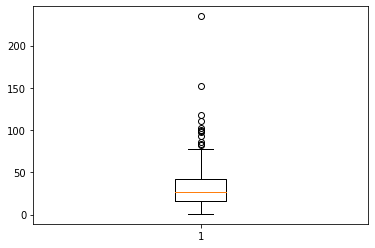

In [247]:
import matplotlib.pyplot as plt
plt.boxplot(impute_d_speeds)
print('mean={mean}, sd={sd}, median={median}'.format(mean = np.mean(impute_speeds), sd= np.std(impute_speeds), median=np.median(impute_speeds)))
## Looks like too many outliers & large standard deviation. So we take the median of the values instead of the mean

In [293]:
## Complete imputation process:

from tqdm.auto import tqdm

final_df = grouped_df.copy()

count_df = grouped_df.groupby(['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural']).size().to_frame(name='counts').reset_index()
to_impute = count_df.loc[(count_df['counts']>0) & (count_df['counts'] < 12), :].reset_index(drop=True).sort_values(by=['counts'], ascending=False)

# to_impute = count_df[count_df['counts'] < 12]

for i in tqdm(range(to_impute.shape[0])):
    pr, cd, ct, st, ir, c = to_impute.iloc[i].tolist()
    cd, st = [str(cd), str(st)]

    subset_idx = (final_df['CDUID']==cd) & (final_df['SACTYPE'] == st) & (final_df['conn_type'] == ct) & (final_df['is_rural'] == ir)
    subset = final_df.loc[subset_idx,:].reset_index(drop=True)

    # list missing timepoints
    missing_t_idxs = np.argwhere(np.array([d in subset['date'].tolist() for d in dates]) == False) 
    
    if len(missing_t_idxs) == 1: # when missing only one timepoint     
        missing_t_idx = missing_t_idxs.item()
        missing_t = dates[missing_t_idx]
        
        if missing_t_idx == 0: # if missing timepoint is 2019-01-01
            new_series = pd.Series([pr, cd, ct, st, ir, missing_t, 0, 0, 1], index = subset.columns)
        else: # if missing timepoint is not 2019-01-01
            impute_target_idx = missing_t_idx - 1 # take the previous timepoint as the observation that we impute from.
            impute_target_row = subset.iloc[impute_target_idx,:]
            new_d_mbps = float(impute_target_row['avg_d_mbps'])
            new_u_mbps = float(impute_target_row['avg_u_mbps'])
            # pr, cd, ct, st, ir, old_date, d, u, im = impute_target_row
            new_series = pd.Series([pr, cd, ct, st, ir, missing_t, new_d_mbps, new_u_mbps, 1], index = subset.columns)

        final_df = final_df.append(new_series, ignore_index=True)
        
    else: # when missing more than one timepoint
        new_series_list = [] 
        for i in missing_t_idxs:
            missing_t_idx = i.item()
            missing_t = dates[missing_t_idx]

            ## Source 1: check whether there's another connection type
            s1_idx = (final_df['CDUID']==cd) & (final_df['SACTYPE'] == st) & (final_df['conn_type'] is not ct) & (final_df['is_rural'] == ir) & (final_df['date'] == missing_t)
            s1_set = final_df.loc[s1_idx, :]

            ## Source 2: pull regions that only differ in SACTYPE
            s2_idx = (final_df['CDUID']==cd) & (final_df['SACTYPE'] is not st) & (final_df['conn_type'] == ct) & (final_df['is_rural'] == ir) & (final_df['date'] == missing_t)
            s2_set = final_df.loc[s2_idx, :]

            ## Source 3: pull regions that only differ in CDUID
            s3_idx = (final_df['CDUID'] is not cd) & (final_df['SACTYPE'] == st) & (final_df['conn_type'] == ct) & (final_df['is_rural'] == ir) & (final_df['date'] == missing_t)
            s3_set = final_df.loc[s3_idx, :]
            
            speed_vars = ['avg_d_mbps', 'avg_u_mbps']
            
            ## extract the download speeds from s1, s2, s3
            impute_d_speeds = pd.concat([s1_set[speed_vars[0]], s2_set[speed_vars[0]], s3_set[speed_vars[0]]], axis=0)

            ## do the same for the upload speed
            impute_u_speeds = pd.concat([s1_set[speed_vars[1]], s2_set[speed_vars[1]], s3_set[speed_vars[1]]], axis=0)
            
            ## Take the median as the new speeds
            new_d_speed = np.median(impute_d_speeds)
            new_u_speed = np.median(impute_u_speeds)

            new_series_list.append(pd.Series([pr, cd, ct, st, ir, missing_t, new_d_speed, new_u_speed, 1], index=subset.columns))
        
        final_df = final_df.append(new_series_list, ignore_index=True)
   
# sort the final df
final_df = final_df.sort_values(by=['PRUID', 'CDUID', 'SACTYPE', 'conn_type', 'is_rural', 'date']).reset_index(drop=True)
# final_df.to_csv('imputed_df.csv', index=False)

  0%|          | 0/452 [00:00<?, ?it/s]

In [256]:
# Sanity check: see if there is any Aggregated regions with < 12 observations:
count_df2 = final_df.groupby(['PRUID', 'CDUID', 'conn_type', 'SACTYPE', 'is_rural']).size().to_frame(name='counts').reset_index()
count_df2 = count_df2.loc[(count_df2['counts']>0), :].reset_index(drop=True).sort_values(by=['counts'], ascending=False)
print(count_df2[count_df2['counts']!=12])

Empty DataFrame
Columns: [PRUID, CDUID, conn_type, SACTYPE, is_rural, counts]
Index: []


In [265]:
n_imputed = np.sum(final_df['imputed']) # there are 1993 imputed rows
n_total = final_df.shape[0]
print("From a total of {nn} rows, there are {ni} imputed rows ({pc}%).".format(nn=n_total, ni = n_imputed, pc = np.round(n_imputed/n_total,4)*100))

From a total of 33252 rows, there are 1993 imputed rows (5.99%).
